In [2]:
#matplotlib
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#import basic modules
import time
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
import cana
from cana.boolean_network import BooleanNetwork

In [141]:
from src.utils import look_up_table, LUT_reduce, get_sunits, config_entropy
from src.MF import find_modules
from src.simulation import run_simulations
from src.dirver_sets import top_selection

# Read Data

In [6]:
net = BooleanNetwork.from_file("./data/drosophila_single_cell.txt", type='logical')

In [7]:
LUT = {node.name: LUT_reduce(look_up_table(node)) for node in net.nodes}
seed_unit = get_sunits(net)

# Mean-Filed Method

In [114]:
modules = find_modules(N = net, 
                       seed_size = 1, 
                       _seeds = [()],
                       seed_unit = seed_unit,
                       iterations = iteration,
                       pinning = {},
                       reduced = True,
                       LUT = LUT,
                       p = 0.5,
                       data = True,
                       pin_start = True,
                       models = 1)

In [144]:
seed_size = 1
iteration = 10

modules = find_modules(N = net, 
                       seed_size = seed_size, 
                       seed_unit = seed_unit,
                       iterations = iteration,
                       pinning = {},
                       reduced = True,
                       LUT = LUT,
                       p = 0.5,
                       data = True,
                       pin_start = True,
                       models = 1)

# Simulation

In [145]:
#check accuracy by comparing to simulations; NOTE: recall/precision based on constant predictions (i.e. s=0 or s=1)
seeds = list(modules.keys())
length = 1 #seed set size
runs = 100 #number of simulations per seed set
simulations = run_simulations(net,
                          seeds,
                          runs=runs,
                          iterations=iteration,
                          unknown_prob=0.5)

# Entropy

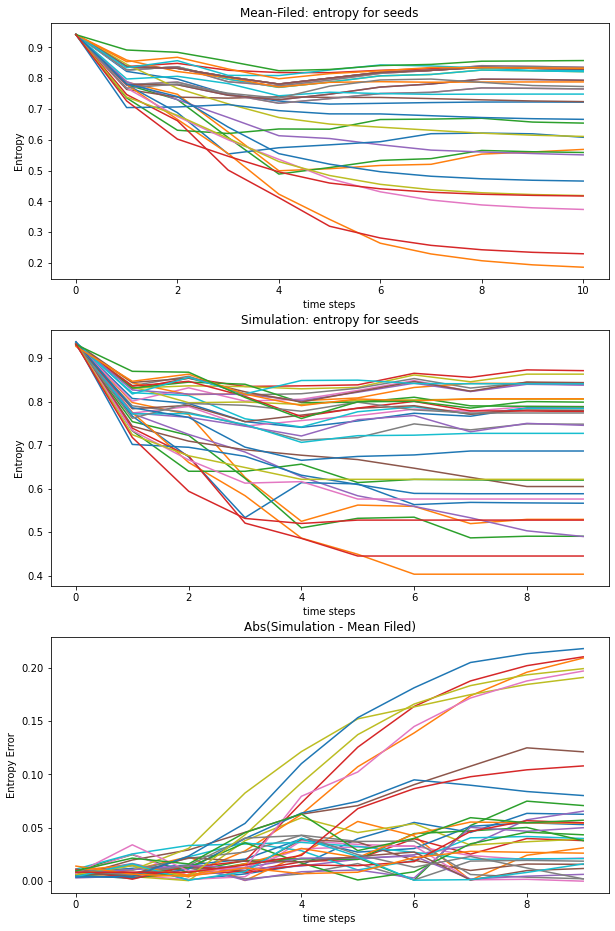

In [146]:
fig, axs = plt.subplots(3,1,figsize=(10,16))
ax = axs[0]
for seed in modules.keys():
    seed_entropy,seed_configs = config_entropy(modules[seed], base=2, normalized=True)
    ax.plot(seed_entropy.values())
ax.set_xlabel("time steps")
ax.set_ylabel("Entropy")
ax.set_title("Mean-Filed: entropy for seeds")

ax = axs[1]
for seed in simulations.keys():
    seed_entropy,seed_configs = config_entropy(simulations[seed], base=2, normalized=True)
    ax.plot(seed_entropy.values())
ax.set_xlabel("time steps")
ax.set_ylabel("Entropy")
ax.set_title("Simulation: entropy for seeds")

ax = axs[2]
for seed in simulations.keys():
    seed_entropy_S,_ = config_entropy(simulations[seed], base=2, normalized=True)
    seed_entropy_M,_ = config_entropy(modules[seed], base=2, normalized=True)
    error = [abs(a-b) for a, b in zip(seed_entropy_S.values(), seed_entropy_M.values())]
    ax.plot(error)
ax.set_xlabel("time steps")
ax.set_ylabel("Entropy Error")
ax.set_title("Abs(Simulation - Mean Filed)")

plt.show()
    

# Select Seeds

In [182]:
selections = top_selection(N = net,
                           seed_unit = seed_unit,
                           reduced = True,
                           LUT = LUT,
                           pinning={},
                           iterations=10,
                           unknown_prob=0.5,
                           models=1,
                           max_seed_size=10)

greedy_entropy = [x[-1] for x in selections]

In [183]:
simulations = run_simulations(net,
                              [x[0] for x in selections],
                              runs=runs,
                              iterations=iteration+1,
                              unknown_prob=0.5)
simulations_entropy = []
for k in simulations.keys():
    _e, _ = config_entropy(simulations[k], base=2, normalized=True)
    e = _e[iteration]
    simulations_entropy.append(e)

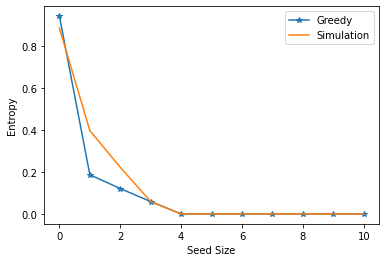

In [187]:
plt.plot(greedy_entropy, "-*", label = "Greedy")
plt.plot(simulations_entropy, label="Simulation")
plt.xlabel("Seed Size")
plt.ylabel("Entropy")
plt.title("Select Seeds Using Greedy")
plt.legend()
plt.show()